In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

33464


## printing params

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [3]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print("PostAnalysis Folder:", postanalysis_folder)
figure_folder = os.path.join(postanalysis_folder, 'Figures_0817')
print("Figure Folder:", figure_folder)

# figure for chromosomes
chrom_figure_folder = os.path.join(figure_folder, 'Chromosomes')
if not os.path.exists(chrom_figure_folder):
    print(f"Create chrom_figure_folder: {chrom_figure_folder}")
    os.makedirs(chrom_figure_folder)
else:
    print(f"Use chrom_figure_folder: {chrom_figure_folder}")

PostAnalysis Folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis
Figure Folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0817
Use chrom_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0817\Chromosomes


## load codebook

In [4]:
import pandas as pd
codebook = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\merged_codebook.csv')

sort_by_region = False
from ImageAnalysis3.structure_tools import distance

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=sort_by_region)

## Load coordinates for subtypes

In [5]:
subclass_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [6]:
subclass_2_chr2ZxysList.keys()

dict_keys(['Oligo', 'L6b', 'Astro', 'VLMC', 'OPC', 'Endo', 'L6 CT', 'Peri', 'Micro', 'L6 IT', 'Sncg', 'L2/3 IT', 'Sst', 'L5 IT', 'Vip', 'Pvalb', 'Lamp5', 'L5/6 NP', 'L5 ET', 'L4/5 IT', 'SMC', 'other'])

## convert to major class

In [7]:
class_2_subclass = {
    'Gluta':['L6b', 'L6 CT', 'L6 IT', 'L5 IT', 'L2/3 IT', 'L5/6 NP', 'L5 ET', ],
    'GABA':['Sncg', 'Sst', 'Vip', 'Pvalb', 'Lamp5', 'L4/5 IT', ],
    'Astro':['Astro', ],
    'Endo':['Endo', ],
    'Micro':['Micro', ],
    'Oligo':['Oligo', 'OPC', ],
}
subclass_2_class = {}
for _cls in class_2_subclass:
    for _subcls in class_2_subclass[_cls]:
        subclass_2_class[_subcls] = _cls

In [8]:
# save if not exists
class_2_chr2ZxysList_filename = os.path.join(postanalysis_folder, 'class_2_chr2Zxys.pkl')
if not os.path.exists(class_2_chr2ZxysList_filename):
    # calculate
    class_2_chr2ZxysList = {_cls:[] for _cls in class_2_subclass.keys()}
    for _subcls, _chr2ZxysList in subclass_2_chr2ZxysList.items():
        if _subcls in subclass_2_class:
            class_2_chr2ZxysList[subclass_2_class[_subcls]].extend(_chr2ZxysList)
    # plot stats
    for _cls in class_2_chr2ZxysList:
        print(_cls, len(class_2_chr2ZxysList[_cls]))
    # save
    print(f"Writing to file: {class_2_chr2ZxysList_filename}")
    pickle.dump(class_2_chr2ZxysList, open(class_2_chr2ZxysList_filename, 'wb'))
else:
    class_2_chr2ZxysList = pickle.load(open(class_2_chr2ZxysList_filename, 'rb'))

## Select good cells

In [45]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict

In [46]:
class_2_selChr2ZxysList = {_cls:[] for _cls in class_2_chr2ZxysList.keys()}
num_chr = 20

for _cls, _chr2ZxysList in class_2_chr2ZxysList.items():
    for _chr2Zxys in _chr2ZxysList:
        if len(_chr2Zxys) >= 19:
             class_2_selChr2ZxysList[_cls].append(Centering_Chr2ZxysListDict(_chr2Zxys))
# plot stats
for _cls in class_2_chr2ZxysList:
    print(_cls, len(class_2_chr2ZxysList[_cls]), len(class_2_selChr2ZxysList[_cls]))

Gluta 13719 2580
GABA 4966 1097
Astro 3822 601
Endo 2891 542
Micro 1523 442
Oligo 6333 2168


# Genome volume

In [23]:
from scipy.spatial import ConvexHull

class_2_volumes = {}
for _cls in class_2_selChr2ZxysList.keys():
    _volumes = []
    for _chr2Zxys in class_2_selChr2ZxysList[_cls]:
        _cell_zxys = np.concatenate([np.array(_v).reshape(-1, 3) for _k,_v in _chr2Zxys.items()])
        _cell_valid_zxys = _cell_zxys[np.isnan(_cell_zxys).any(1)==False]
        _hull = ConvexHull(_cell_valid_zxys)
        _volumes.append(_hull.volume)
    class_2_volumes[_cls] = _volumes

<IPython.core.display.Javascript object>


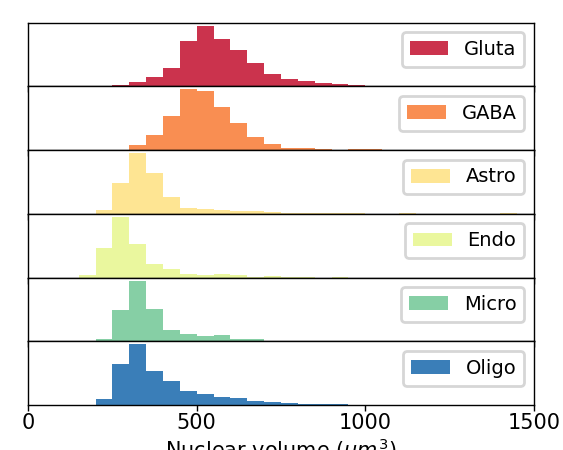

In [44]:
from matplotlib.cm import Spectral

sel_keys = list(class_2_volumes.keys())
plt.style.use('default')

#fig, axes = plt.subplots(,1, figsize=(6,5), sharex=True, sharey=False, dpi=100)
fig, axes = plt.subplots(len(sel_keys),1, figsize=(_single_col_width*1.25, _single_col_width),
                         sharex=True, dpi=200)

for _i, _ax in enumerate(axes):
    _key = sel_keys[_i]
    _ax.hist(class_2_volumes[_key], bins=np.arange(0,1500,50), 
             alpha=1, label=f'{_key}', color=Spectral((_i+0.5)/len(sel_keys)))
    _ax.legend(fontsize=_font_size-0.5)
    
    _ax.tick_params('x', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, )
    _ax.tick_params('y', labelsize=_font_size, 
                    width=0, length=0,
                    labelleft=False,
                    pad=1, )
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]

_ax.set_xticks(np.arange(0,2000,500))
_ax.set_xlim([0,1500])
_ax.set_xlabel(f"Nuclear volume ($\u03BCm^3$)", fontsize=_font_size, labelpad=1)
fig.savefig(os.path.join(chrom_figure_folder, f"volume_histogram_class.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
fig.subplots_adjust(wspace=0.1, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.1)


# Chromosome density

In [17]:
_px = 0.1
_sigma = 0.25
_im_radius = 5

num_threads=32

import multiprocessing as mp
from ImageAnalysis3.structure_tools.chromosome import convert_chr2Zxys_2_Cloud
reload(ia.structure_tools.chromosome)


<module 'ImageAnalysis3.structure_tools.chromosome' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\structure_tools\\chromosome.py'>

In [18]:
class_2_chr2densities = {}

for _class, _chr2ZxysList in class_2_chr2ZxysList.items():
    _args = []
    for _chr2Zxys in _chr2ZxysList:
        _args.append(
            (_chr2Zxys, _px, _im_radius, _sigma, [1,2], 20, 0.5, False, False)
        )
    with mp.Pool(num_threads) as _pool:
        print(f"--- {_class}, {len(_args)} cells processing by {num_threads} threads", end=' ')
        _start_time = time.time()
        # pool
        _chr2densities_List = _pool.starmap(
            ia.structure_tools.chromosome.convert_chr2Zxys_2_Cloud, _args[:100], chunksize=1)
        _pool.close()
        _pool.join()
        _pool.terminate() 
        print(f"finish in {time.time()-_start_time:.3f}s. ")
    
    class_2_chr2densities[_class] = _chr2densities_List
    break

--- Gluta, 13719 cells processing by 32 threads finish in 31.150s. 


In [19]:
chromosome_th = 2

class_2_chr2volumes = {_cls:{_chr:[] for _chr in np.unique(codebook['chr'])}
                       for _cls in class_2_chr2densities}
for _class, _chr2densities_List in class_2_chr2densities.items():
    for _chr2densities in _chr2densities_List:
        for _chr, _dens in _chr2densities.items():
            for _den in _dens:
                if _den.any():
                    class_2_chr2volumes[_class][_chr].append(
                        np.sum(_den > chromosome_th) * _px**3
                    )

In [20]:
for _chr2densities in _chr2densities_List:
    if '4' in _chr2densities and _chr2densities['4'].any():
        break

<IPython.core.display.Javascript object>


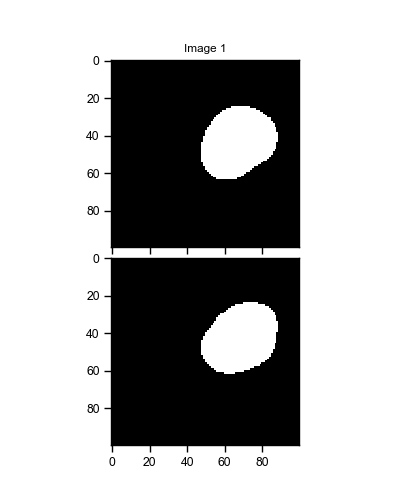

In [23]:
visual_tools.imshow_mark_3d_v2(_chr2densities['4'] > chromosome_th )